In [13]:
from google.colab import drive
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
sql_file_path = '/content/drive/MyDrive/Python_SQL_Project/Sql_Query.sql'
with open(sql_file_path, 'r') as file:
    sql_commands = file.read()
print("SQL queries loaded successfully into 'sql_commands' variable.")

SQL queries loaded successfully into 'sql_commands' variable.


In [15]:
customers = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/customers.csv')
geolocation = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/geolocation.csv')
order_items = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/order_items.csv')
orders = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/orders.csv')
payments = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/payments.csv')
products = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/products.csv')
sellers = pd.read_csv('/content/drive/MyDrive/Python_SQL_Project/sellers.csv')

conn = sqlite3.connect(':memory:')

customers.to_sql('customers', conn, if_exists='replace', index=False)
geolocation.to_sql('geolocation', conn, if_exists='replace', index=False)
order_items.to_sql('order_items', conn, if_exists='replace', index=False)
orders.to_sql('orders', conn, if_exists='replace', index=False)
payments.to_sql('payments', conn, if_exists='replace', index=False)
products.to_sql('products', conn, if_exists='replace', index=False)
sellers.to_sql('sellers', conn, if_exists='replace', index=False)

print("In-memory SQLite database created and all DataFrames loaded as tables.")

In-memory SQLite database created and all DataFrames loaded as tables.


In [16]:
sql_queries = [query.strip() for query in sql_commands.split(';') if query.strip()]
print(f"Found {len(sql_queries)} SQL queries.")

Found 15 SQL queries.


In [17]:
import re

query_results = {}

# Define common replacements using regex patterns
replacements = {
    # Handle column name 'product_category' which is 'product category' in DataFrame
    r'(\bp\.)?product_category\b': r'\1"product category"',
    # Handle MONTH() function
    r'\bMONTH\s*\(': "strftime('%m', ",
    # Handle YEAR() function
    r'\bYEAR\s*\(': "strftime('%Y', ",
    # Handle DATEADD(MONTH, X, column) for SQLite compatibility
    r'\bDATEADD\(MONTH,\s*(\d+),\s*([a-zA-Z0-9_.]+)\)': r"DATE(\2, '+ \1 months')"
}

for i, query in enumerate(sql_queries):
    clean_query = query.split('*/')[-1].strip()

    # Apply all defined replacements to the query string
    for pattern, replacement in replacements.items():
        clean_query = re.sub(pattern, replacement, clean_query, flags=re.IGNORECASE)

    try:
        if clean_query.lower().startswith('select'):
            df_name = f'query_result_{i+1}'
            query_results[df_name] = pd.read_sql_query(clean_query, conn)
            print(f"Executed query {i+1} (SELECT) and stored in '{df_name}'. Shape: {query_results[df_name].shape}")
        else:
            conn.execute(clean_query)
            conn.commit()
            print(f"Executed query {i+1} (DDL/DML).")
    except Exception as e:
        print(f"Error executing query {i+1}: {e}\nQuery: {clean_query}")

# Close the database connection after all queries are executed
conn.close()
print("Database connection closed.")

Executed query 1 (SELECT) and stored in 'query_result_1'. Shape: (4119, 1)
Executed query 2 (SELECT) and stored in 'query_result_2'. Shape: (1, 1)
Executed query 3 (SELECT) and stored in 'query_result_3'. Shape: (74, 2)
Executed query 4 (SELECT) and stored in 'query_result_4'. Shape: (1, 1)
Executed query 5 (SELECT) and stored in 'query_result_5'. Shape: (27, 2)
Executed query 6 (SELECT) and stored in 'query_result_6'. Shape: (0, 2)
Executed query 7 (SELECT) and stored in 'query_result_7'. Shape: (98666, 2)
Executed query 8 (SELECT) and stored in 'query_result_8'. Shape: (74, 2)
Executed query 9 (DDL/DML).
Executed query 10 (SELECT) and stored in 'query_result_10'. Shape: (3095, 3)
Executed query 11 (DDL/DML).
Executed query 12 (SELECT) and stored in 'query_result_12'. Shape: (26, 4)
Executed query 13 (SELECT) and stored in 'query_result_13'. Shape: (4, 3)
Executed query 14 (DDL/DML).
Executed query 15 (DDL/DML).
Database connection closed.


### Top 10 Product Categories by Total Revenue

This bar chart visualizes the top 10 product categories based on their total revenue. It helps in identifying which product categories are the biggest revenue drivers for the business.

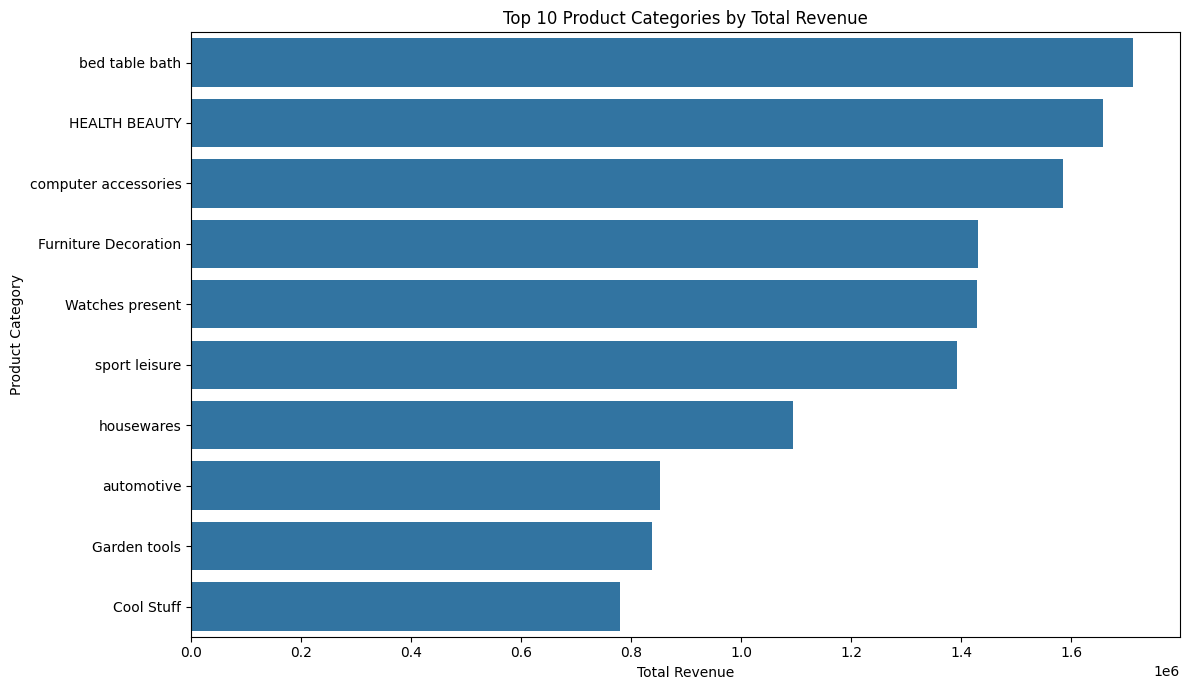

In [18]:
plt.figure(figsize=(12, 7))
sns.barplot(x='total_revenue', y='product category', data=query_results['query_result_3'].sort_values(by='total_revenue', ascending=False).head(10))
plt.title('Top 10 Product Categories by Total Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()


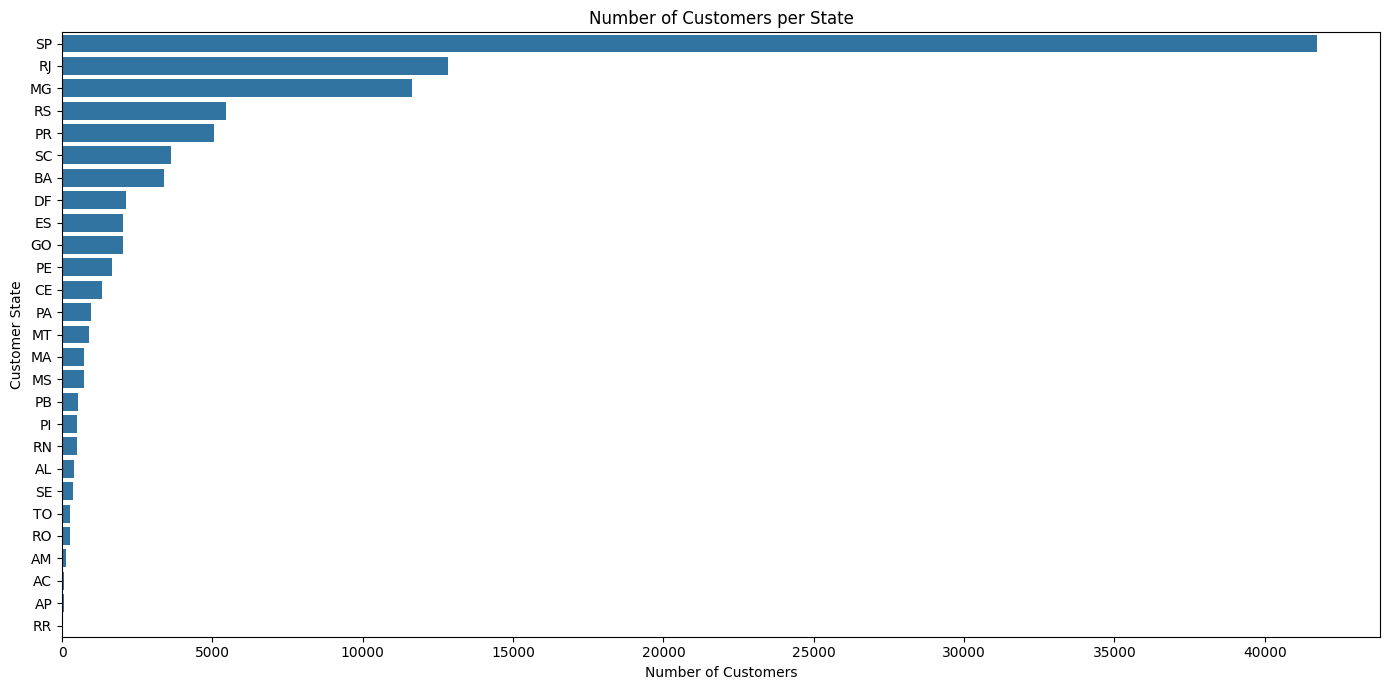

In [19]:
#Number Of Customer per state
plt.figure(figsize=(14, 7))
sns.barplot(x='Total_customers', y='customer_state', data=query_results['query_result_5'].sort_values(by='Total_customers', ascending=False))
plt.title('Number of Customers per State')
plt.xlabel('Number of Customers')
plt.ylabel('Customer State')
plt.tight_layout()
plt.show()

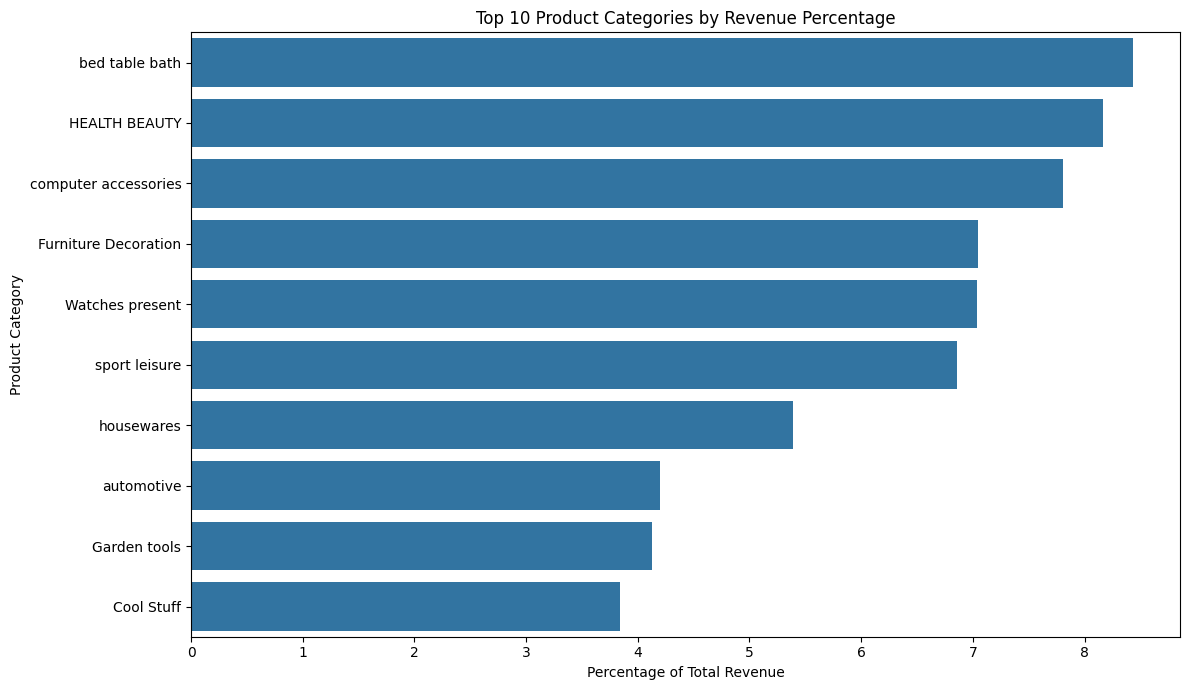

In [20]:
# Top 10 Product Categories by revenue percentage
plt.figure(figsize=(12, 7))
sns.barplot(x='pr', y='category', data=query_results['query_result_8'].sort_values(by='pr', ascending=False).head(10))
plt.title('Top 10 Product Categories by Revenue Percentage')
plt.xlabel('Percentage of Total Revenue')
plt.ylabel('Product Category')
plt.tight_layout()
plt.show()

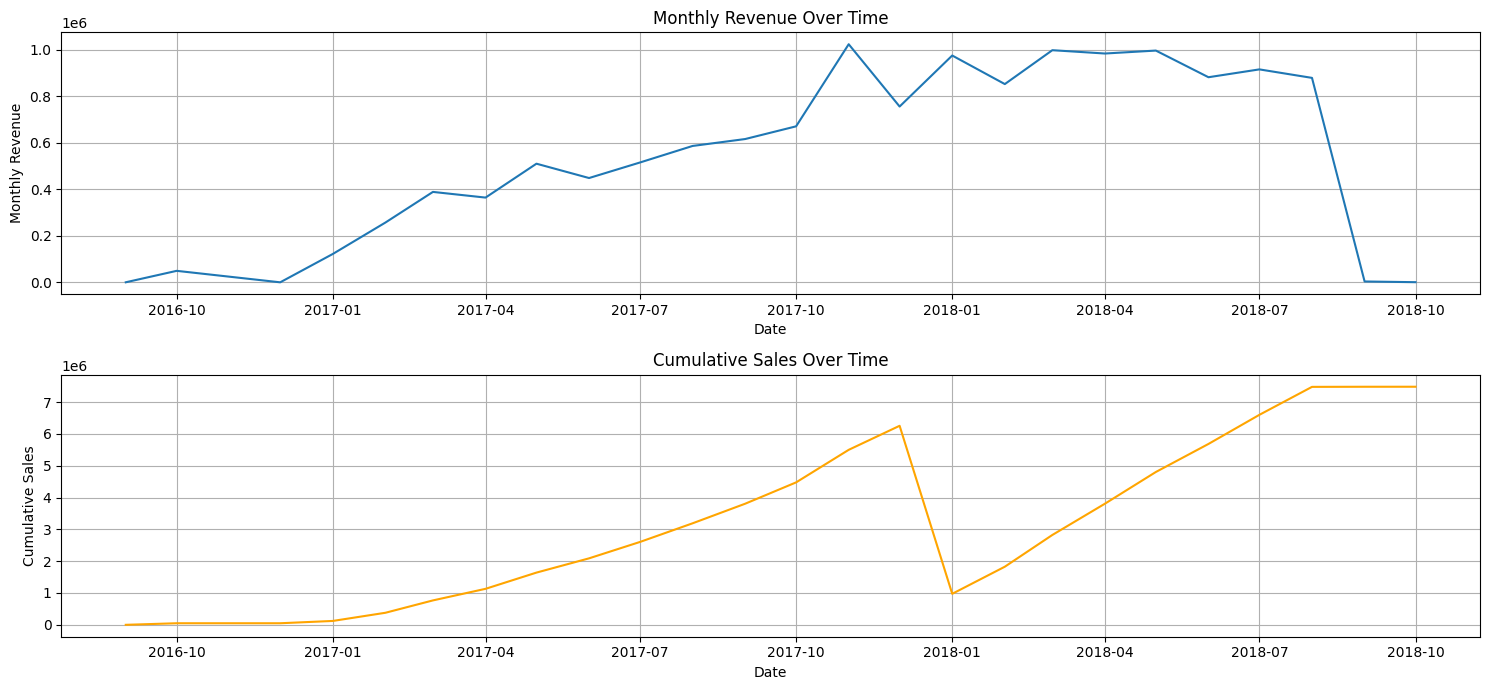

In [21]:
#Monthly Revenue Over Time and Cumulative Sales Over Time
df_sales_trend = query_results['query_result_12'].copy()
# Filter out rows where 'years' or 'months' are None
df_sales_trend = df_sales_trend.dropna(subset=['years', 'months'])
df_sales_trend['year_month'] = df_sales_trend['years'].astype(str) + '-' + df_sales_trend['months'].astype(str).str.zfill(2)
df_sales_trend['year_month'] = pd.to_datetime(df_sales_trend['year_month'])
df_sales_trend = df_sales_trend.sort_values(by='year_month')

plt.figure(figsize=(15, 7))

# Plot Monthly Revenue
plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
sns.lineplot(x='year_month', y='rev', data=df_sales_trend)
plt.title('Monthly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Revenue')
plt.grid(True)

# Plot Cumulative Sales
plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
sns.lineplot(x='year_month', y='cum_sales', data=df_sales_trend, color='orange')
plt.title('Cumulative Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.grid(True)

plt.tight_layout()
plt.show()

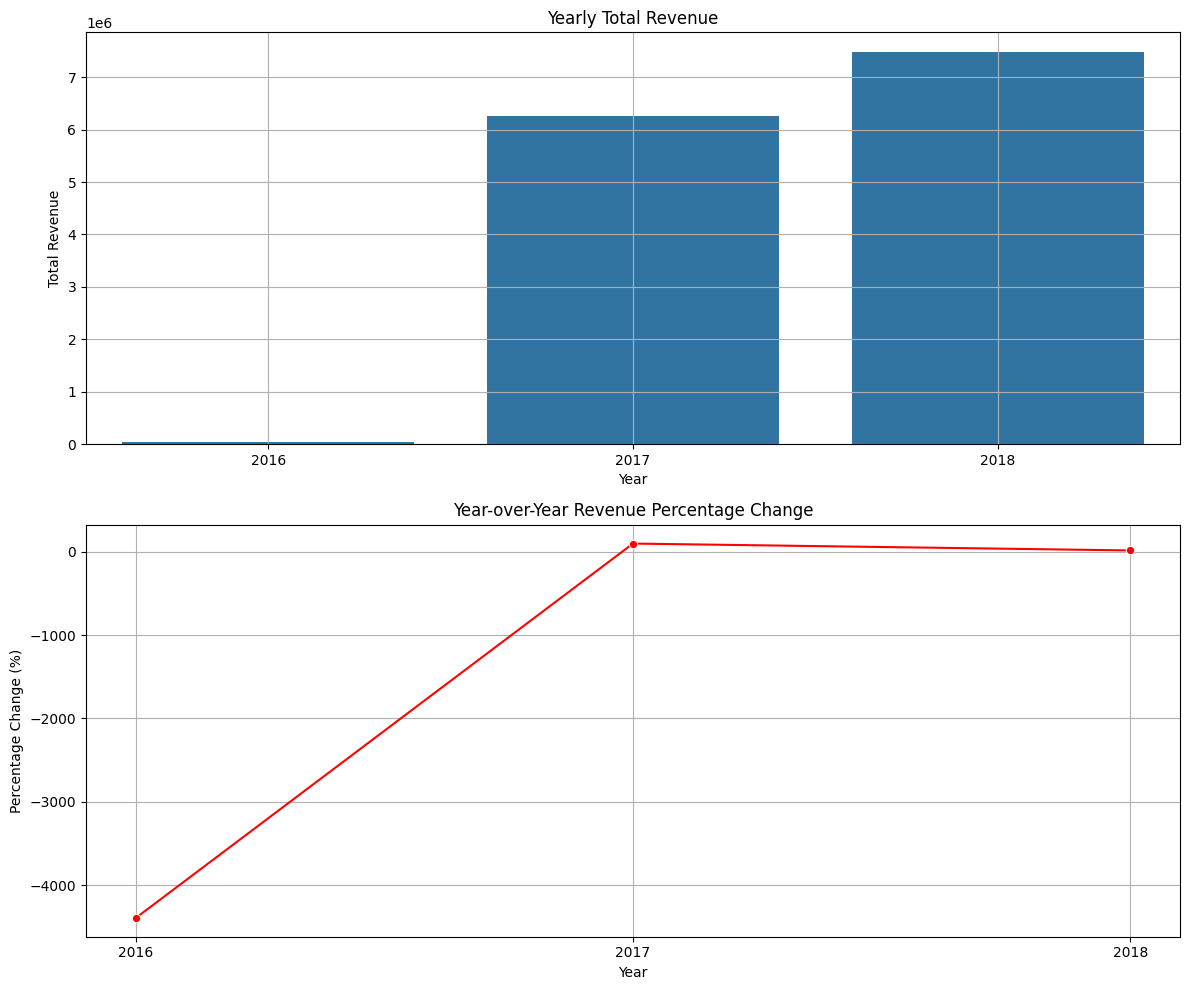

In [22]:
# Yearly Revenue and Year-over-Year Revenue Percentage Change
plt.figure(figsize=(12, 10))

# Subplot 1: Yearly Revenue
plt.subplot(2, 1, 1)
sns.barplot(x='years', y='revenue', data=query_results['query_result_13'])
plt.title('Yearly Total Revenue')
plt.xlabel('Year')
plt.ylabel('Total Revenue')
plt.grid(True)

# Subplot 2: Year-over-Year Revenue Percentage Change
plt.subplot(2, 1, 2)
sns.lineplot(x='years', y='perc_change', data=query_results['query_result_13'], marker='o', color='red')
plt.title('Year-over-Year Revenue Percentage Change')
plt.xlabel('Year')
plt.ylabel('Percentage Change (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Top-Performing Product Categories**: The "bed table bath" category consistently leads in both total revenue and percentage contribution to overall revenue, followed by "health beauty" and "sports leisure".
*   **Customer Concentration**: Sao Paulo (SP) is the dominant customer base, hosting the largest number of customers. Rio de Janeiro (RJ) and Minas Gerais (MG) also have significant customer populations but are considerably smaller than SP.
*   **Sales Trends**: Monthly revenue shows a clear upward trajectory, particularly evident from 2017 into 2018, albeit with some monthly fluctuations. Cumulative sales demonstrate steady growth over the period analyzed, indicating continuous business expansion.
*   **Annual Revenue Growth**: Total revenue saw substantial increases year-over-year from 2016 to 2017 and continued to grow into 2018.
*   **Year-over-Year Growth Rate**: While earlier periods exhibited strong year-over-year revenue growth, this growth rate appeared to stabilize or slightly decline towards 2018.

### Insights or Next Steps

*   **Strategic Focus on Key Markets and Products**: Given the high concentration of customers in Sao Paulo and the strong performance of "bed table bath," "health beauty," and "sports leisure" categories, marketing and sales efforts should be optimized and potentially expanded within these established segments.
*   **Investigate Growth Rate Changes**: Analyze the reasons behind the stabilization or slight decrease in the year-over-year growth rate towards 2018. This could involve exploring market saturation, increased competition, or changes in customer purchasing behavior to inform future growth strategies.
